# KNN Classifier using Bluetooth data

<p>Jupyter Notebook which aims to explore the ML algorithm K-Nearest Neighbors as a Classifier algorithm using the BLE technologies moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('../radiomapBluetoothWiFiclassifier.csv')
beacon_index = find_beacon_index()
X_train = dataset.iloc[:,beacon_index:]
Y_train = dataset.iloc[:,3:4]
nan_filler = X_train.min().min()*1.010
X_train = X_train.replace(0, np.nan)
X_train = X_train.fillna(nan_filler)

## Beacons Graphical Display
Graphical display with the average strength signal transmitted by each beacon

<BarContainer object of 2 artists>

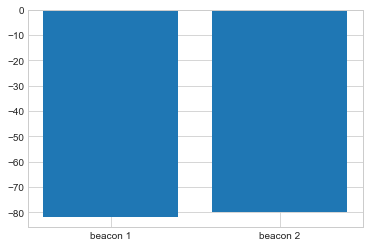

In [5]:
count_beacons = {}
counter = 1
for beacon in X_train:
    mean_value = dataset[beacon].mean()
    count_beacons['beacon ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_beacons)),list(count_beacons.values()),align='center',tick_label=list(count_beacons.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

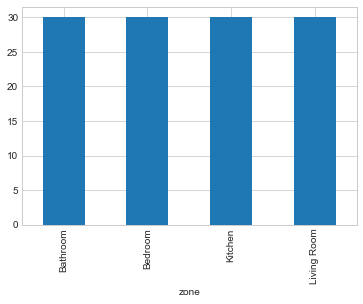

In [6]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

### Bluetooth Signal Strength

Text(0, 0.5, 'Probability')

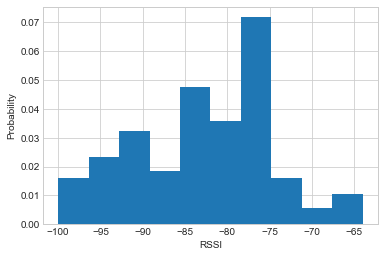

In [7]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize KNN Parameters arrays
Initialization of the arrays with the different possible values for the parameters of KNN Classifier function

In [8]:
#Knn Configurable parameters arary
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
weights = ["uniform","distance"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["zone"].map(str)

## Statistics Output Format
Structure of the statistical output of each call to the KNN Regression Function

In [9]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

## Configurable KNN Classifier Function 
Configurable function to aplpy the knn to a training set

In [10]:
def compute_KNN_with_Classifier(flag = 1,trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=4,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data.values.ravel())
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data.values,testY_data.values.ravel(),cv = cross_validation,groups=default_data_scenario_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    # Structure data to statistics
    statistics = pd.DataFrame(report).transpose()
    statistical_array = list()
    coord_cols = ['zone']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame(np.where(predictions[coord_cols] != result[coord_cols],1,0), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    if flag == 0:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(result)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

## Experiments

### 1st Experiment - Running KNN function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_KNN_with_Classifier(flag=0,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

Confusion Matrix:
[[26  2  2  0]
 [ 0 29  1  0]
 [ 1  0 29  0]
 [ 7  3  6 14]]


,precision,recall,f1-score,support
Bathroom,0.764706,0.866667,0.812500,30.000000
Bedroom,0.852941,0.966667,0.906250,30.000000
Kitchen,0.763158,0.966667,0.852941,30.000000
Living Room,1.000000,0.466667,0.636364,30.000000
accuracy,0.816667,0.816667,0.816667,0.816667
macro avg,0.845201,0.816667,0.802014,120.000000
weighted avg,0.845201,0.816667,0.802014,120.000000


,zone,zone_predicted,error
0,Kitchen,Kitchen,0
1,Kitchen,Kitchen,0
2,Kitchen,Kitchen,0
3,Kitchen,Kitchen,0
4,Kitchen,Kitchen,0
...,...,...,...
115,Bathroom,Bathroom,0
116,Bathroom,Bedroom,1
117,Bathroom,Kitchen,1
118,Bathroom,Bathroom,0


,mae,mse,rmse,precision,accuracy,f1-score
0,0.183333,0.183333,0.428174,0.841125,0.816667,0.804107


### 2nd Experiment - Finding the best k parameter with Grid Search

In [12]:
def grid_search():
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=10)
    #fit model to data
    estimator.fit(X_train.values,Y_train.values.ravel())
    print(estimator.best_params_)
    return estimator.best_params_['knn__n_neighbors']


In [13]:
best_knn = grid_search()

{'knn__n_neighbors': 11}


### 3rd Experiment - Graphical Display of k accuracy

In [14]:
def find_fit_k():
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=10)
    #fit model to data
    estimator.fit(X_train.values, Y_train.values.ravel())
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-validated accuracy')

Max accuracy:  0.7833333333333334


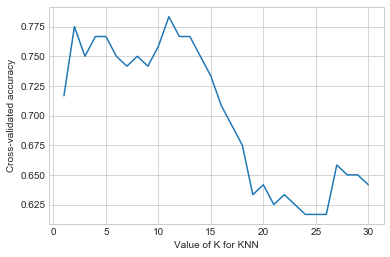

In [15]:
find_fit_k()

### 4th Experiment - Running the KNN function with default parameters and Hold-out Cross Validation

,mae,mse,rmse,precision,accuracy,f1-score,test_size
0,0.166667,0.166667,0.408248,0.851190,0.833333,0.831293,0.1
4,0.200000,0.200000,0.447214,0.801557,0.800000,0.786132,0.5
3,0.229167,0.229167,0.478714,0.764539,0.770833,0.756160,0.4
1,0.250000,0.250000,0.500000,0.776531,0.750000,0.732326,0.2
5,0.277778,0.277778,0.527046,0.710505,0.722222,0.704524,0.6
2,0.333333,0.333333,0.577350,0.645238,0.666667,0.649011,0.3
6,0.392857,0.392857,0.626783,0.624972,0.607143,0.606503,0.7
7,0.416667,0.416667,0.645497,0.679447,0.583333,0.601470,0.8
8,0.462963,0.462963,0.680414,0.541391,0.537037,0.502618,0.9


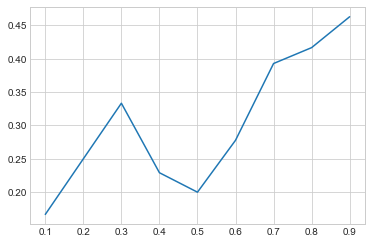

In [16]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    Y_train_split = Y_train_split.reset_index(drop=True)
    Y_test_split = Y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae'],))
plt.plot(statistics['test_size'],statistics['mae'])

### 5th Experiment -  Running the KNN function with default parameters and Stratified K-Fold cross validation

,mae,mse,rmse,precision,accuracy,f1-score,folds
8,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,10
7,0.250000,0.250000,0.500000,0.743723,0.750000,0.741240,9
3,0.258333,0.258333,0.508265,0.732617,0.741667,0.734271,5
6,0.266667,0.266667,0.516398,0.721125,0.733333,0.722808,8
5,0.275000,0.275000,0.524404,0.712723,0.725000,0.714372,7
4,0.283333,0.283333,0.532291,0.700955,0.716667,0.703214,6
2,0.333333,0.333333,0.577350,0.656330,0.666667,0.660404,4
0,0.408333,0.408333,0.639010,0.555511,0.591667,0.552198,2
1,0.558333,0.558333,0.747217,0.425560,0.441667,0.425995,3


Number of Folds:  10


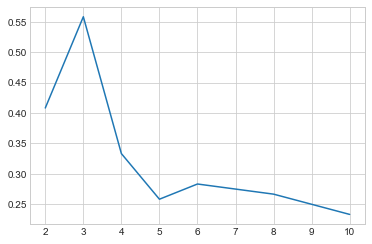

In [17]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,11)
results = list()
for cv in cross_validation_list:
    result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### 6th Experiment -  Running the KNN function with default parameters and Leave One Group Out cross validation

In [18]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,default_data_scenario_groups,groups=default_data_scenario_groups)
loo = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,precision,accuracy,f1-score
0,1.0,1.0,1.0,0.0,0.0,0.0


### 8th Experiment - Compare cross validation methods

,mae,mse,rmse,precision,accuracy,f1-score,method
2,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,Stratified K-Fold
1,0.462963,0.462963,0.680414,0.541391,0.537037,0.502618,HoldOut
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO


Selected cross validation method:  Stratified K-Fold


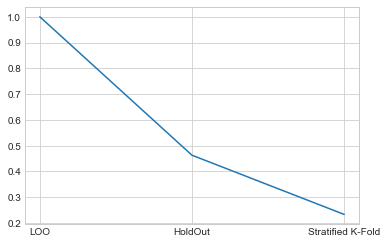

In [19]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method']
results = list()
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skfold = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 9th Experiment - Running the KNN function with the different weights

,mae,mse,rmse,precision,accuracy,f1-score,weights
1,0.225000,0.225000,0.474342,0.768829,0.775000,0.769424,distance
0,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,uniform


Selected weight:  distance


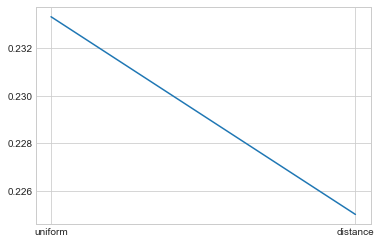

In [20]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','weights']
results = list()
for weight in weights:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,weights=weight)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                           weights = weight)
    result.append(weight)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

### 10th Experiment - Running the KNN function with the different preprocessing methods

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc
1,0.225000,0.225000,0.474342,0.773279,0.775000,0.761161,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))"
2,0.225000,0.225000,0.474342,0.770884,0.775000,0.763283,MaxAbsScaler,MaxAbsScaler(copy=True)
3,0.225000,0.225000,0.474342,0.770884,0.775000,0.763283,None,None
0,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,StandardScaler,"StandardScaler(copy=True, with_mean=True, with..."


Selected Preprocessing:  MinMaxScaler


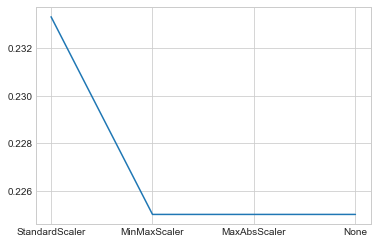

In [21]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = selected_fold)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 11th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,precision,accuracy,f1-score,algorithms
0,0.225000,0.225000,0.474342,0.770687,0.775000,0.763607,brute
1,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,kd_tree
2,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,ball_tree
3,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,auto


Selected Algorithm:  brute


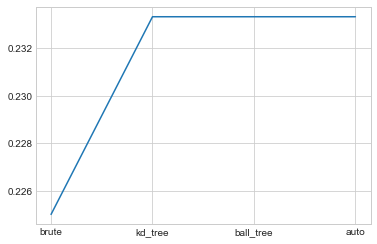

In [22]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','algorithms']
results = list()
for algorithm in algorithms:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            algorithm = algorithm)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            algorithm = algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithms'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithms'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 12th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,precision,accuracy,f1-score,distance
2,0.216667,0.216667,0.465475,0.780050,0.783333,0.766669,canberra
0,0.233333,0.233333,0.483046,0.760154,0.766667,0.756188,euclidean
1,0.241667,0.241667,0.491596,0.750358,0.758333,0.745712,manhattan
3,0.250000,0.250000,0.500000,0.744898,0.750000,0.743014,braycurtis


Selected Distance Metric:  canberra


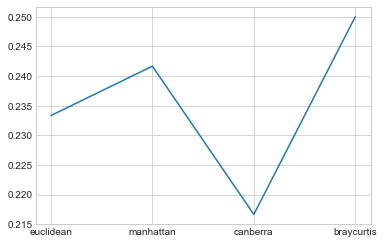

In [23]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance']
results = list()
for distance in distance_metris:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            metric = distance)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            metric = distance)
    result.append(distance)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance_metric = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected Distance Metric: ",selected_distance_metric)

### 13th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [24]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance','preprocessing','weights']
results = list()
k_range = range(1, 31)
for distance in distance_metris:
    for preprocessing in scaler:
        for weight in weights:
            if selected_method == 'LOO':
                cv = LeaveOneGroupOut()
                splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
                result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)  
            elif selected_method =='Stratified K-Fold':
                result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = selected_fold,
                                                    metric = distance,weights=weight)
            else:
                result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocessing,
                                                    metric = distance,weights=weight)
            result.append(distance)
            if(preprocessing is None):
                regex = 'None'
            else:
                regex = re.search('(\w+)\(',str(preprocessing)).group(1)
            result.append(regex)
            result.append(weight)
            results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,precision,accuracy,f1-score,distance,preprocessing,weights
23,0.191667,0.191667,0.437798,0.806839,0.808333,0.803709,canberra,None,distance
21,0.191667,0.191667,0.437798,0.806839,0.808333,0.803709,canberra,MaxAbsScaler,distance
19,0.191667,0.191667,0.437798,0.805655,0.808333,0.801224,canberra,MinMaxScaler,distance
15,0.200000,0.200000,0.447214,0.798769,0.800000,0.794278,manhattan,None,distance
31,0.200000,0.200000,0.447214,0.798001,0.800000,0.794265,braycurtis,None,distance
18,0.208333,0.208333,0.456435,0.784673,0.791667,0.781273,canberra,MinMaxScaler,uniform
29,0.208333,0.208333,0.456435,0.788351,0.791667,0.786619,braycurtis,MaxAbsScaler,distance
7,0.208333,0.208333,0.456435,0.787064,0.791667,0.786337,euclidean,None,distance
13,0.208333,0.208333,0.456435,0.788351,0.791667,0.786619,manhattan,MaxAbsScaler,distance
25,0.216667,0.216667,0.465475,0.779877,0.783333,0.778028,braycurtis,StandardScaler,distance


### 14th Experiment: Running the KNN function with data filtered 

In [25]:
def apply_filter():
    statistical_cols =  ['mae','mse','rmse','precision','accuracy','f1-score','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_KNN_with_Classifier(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                                 metric = selected_distance_metric,algorithm=selected_algorithm,cross_validation = selected_fold,
                                                 weights=selected_weight)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    y_train = median_pd.iloc[:,0:1]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                         metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        means_list = [zone]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,1:]
    y_train = mean_pd.iloc[:,0:1]
    nan_filler = X_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                         metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Mean')
    return result

,mae,mse,rmse,precision,accuracy,f1-score,filter
2,0.225000,0.225000,0.474342,0.766738,0.775000,0.767574,No Filter
0,0.366667,0.366667,0.605530,0.652213,0.633333,0.626083,Median
1,0.533333,0.533333,0.730297,0.461515,0.466667,0.458269,Mean


Selected Filter:  No Filter


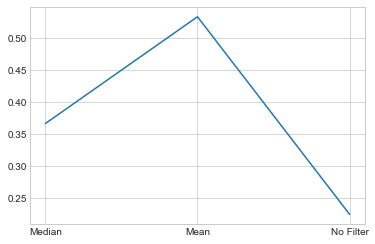

In [26]:
selected_filter = apply_filter()

# Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [27]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance','Filtering']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance_metric,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('KNN Classifier Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../parameters_results.csv',mode='a',index=False,header=False)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance,Filtering
0,11,Stratified K-Fold,distance,MinMaxScaler,brute,canberra,No Filter


### Best Result

In [28]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_KNN_with_Classifier(flag=0,n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
elif selected_method =='Stratified K-Fold':
    result = compute_KNN_with_Classifier(flag=0,n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = selected_fold,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
else:
    result = compute_KNN_with_Classifier(flag=0,trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=selected_preprocesssing_func,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('KNN Classifier Bluetooth')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../tests_results.csv',mode='a',index=False,header=False)

Confusion Matrix:
[[26  0  1  3]
 [ 0 27  0  3]
 [ 1  0 28  1]
 [ 7  4  5 14]]


,precision,recall,f1-score,support
Bathroom,0.764706,0.866667,0.812500,30.000000
Bedroom,0.870968,0.900000,0.885246,30.000000
Kitchen,0.823529,0.933333,0.875000,30.000000
Living Room,0.666667,0.466667,0.549020,30.000000
accuracy,0.791667,0.791667,0.791667,0.791667
macro avg,0.781467,0.791667,0.780441,120.000000
weighted avg,0.781467,0.791667,0.780441,120.000000


,zone,zone_predicted,error
0,Kitchen,Kitchen,0
1,Kitchen,Kitchen,0
2,Kitchen,Kitchen,0
3,Kitchen,Kitchen,0
4,Kitchen,Kitchen,0
...,...,...,...
115,Bathroom,Bathroom,0
116,Bathroom,Bathroom,0
117,Bathroom,Kitchen,1
118,Bathroom,Bathroom,0


,mae,mse,rmse,precision,accuracy,f1-score
0,0.208333,0.208333,0.456435,0.782924,0.791667,0.782045
